In [1]:
from collections import Counter
import itertools

import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import squareform
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import yfinance as yf

from mst import MinimumSpanningTree
from utils import compute_log_returns, convert_to_distance_matrix, get_condensed_distance_matrix
from graph import build_graph, draw_graph

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

# Introduction

In this notebook, I tried to calculate the distance between stocks through the correlation of log-returns and then visualize them through hierarchical clustering(Denodrogram, Minimum Spanning Tree).

 Next, I de-noised distances that I had calculated above step by using clustering-based filtering. Lastly, I used new distances and visualized stocks as in the previous steps and compared those with the previous results.


### loading price data

I used [s&p500 list](https://datahub.io/core/s-and-p-500-companies#resource-constituents) and randomly sampled 50 from the list by sector. Then, I already downloaded 1 year(19.3.11~20.3.10) of daily historical prices of them. You can find price data from 'sp50_1year.csv' file.

In [3]:
# from "2019-03-11" to "2020-03-10"
prices_df = pd.read_csv("sp50_1year.csv", index_col=0)
tickers = list(prices_df)

Also, You can check information of ticker from 'selected_tickers_info.csv' file

In [4]:
ticker_info_df = pd.read_csv("selected_tickers_info.csv")
ticker_info_df.head()

,Symbol,Name,Sector
0,ARE,Alexandria Real Estate Equities Inc,Real Estate
1,ALLE,Allegion,Industrials
2,AGN,"Allergan, Plc",Health Care
3,ALL,Allstate Corp,Financials
4,AME,AMETEK Inc.,Industrials


In [5]:
len(ticker_info_df['Sector'].unique())

11

We will use sector informations for visualization for later.

In [6]:
sector_map = ticker_info_df.set_index('Symbol')['Sector'].to_dict()
sector_map

{'ARE': 'Real Estate',
 'ALLE': 'Industrials',
 'AGN': 'Health Care',
 'ALL': 'Financials',
 'AME': 'Industrials',
 'AIV': 'Real Estate',
 'ADM': 'Consumer Staples',
 'T': 'Telecommunication Services',
 'CHRW': 'Industrials',
 'CTL': 'Telecommunication Services',
 'GLW': 'Information Technology',
 'COST': 'Consumer Staples',
 'CMI': 'Industrials',
 'DVN': 'Energy',
 'DFS': 'Financials',
 'DISCK': 'Consumer Discretionary',
 'DG': 'Consumer Discretionary',
 'DTE': 'Utilities',
 'EMN': 'Materials',
 'EOG': 'Energy',
 'ESS': 'Real Estate',
 'EL': 'Consumer Staples',
 'RE': 'Financials',
 'EXPD': 'Industrials',
 'FAST': 'Industrials',
 'FLIR': 'Information Technology',
 'FMC': 'Materials',
 'GPS': 'Consumer Discretionary',
 'JBHT': 'Industrials',
 'JPM': 'Financials',
 'LOW': 'Consumer Discretionary',
 'MAR': 'Consumer Discretionary',
 'MET': 'Financials',
 'MU': 'Information Technology',
 'NOV': 'Energy',
 'NWSA': 'Consumer Discretionary',
 'NI': 'Utilities',
 'NUE': 'Materials',
 'PYPL': 

In [7]:
sector_index = {}
for i, sector in enumerate(set(sector_map.values())):
    sector_index[sector] = i

we can check there are total eleven sectors

In [8]:
sector_index

{'Real Estate': 0,
 'Financials': 1,
 'Information Technology': 2,
 'Utilities': 3,
 'Health Care': 4,
 'Industrials': 5,
 'Energy': 6,
 'Telecommunication Services': 7,
 'Consumer Staples': 8,
 'Consumer Discretionary': 9,
 'Materials': 10}

### Calculating log returns

In [9]:
log_return_df = compute_log_returns(prices_df)
log_return_df.head()

,ADM,AGN,AIV,ALL,ALLE,AME,ARE,CHRW,CMI,COST,...,RE,SLG,SNA,SO,SPGI,SWKS,SYF,T,TPR,VZ
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-12,0.001633,0.007609,0.009189,-0.000425,0.002593,0.000624,0.005437,-0.001351,0.002402,0.014136,...,0.001376,0.008852,0.002499,0.005433,0.001317,0.009527,0.005916,0.013476,-0.002366,-0.002608
2019-03-13,0.008355,0.018174,0.000596,-0.005543,0.009302,0.011784,0.008455,0.003712,-0.009259,0.014574,...,0.000367,-0.005236,-0.008459,0.000967,0.011078,-0.005975,0.021803,-0.011492,0.002366,0.003997
2019-03-14,0.001847,-0.004462,0.008903,0.003202,-0.006736,-0.003713,0.003672,0.002914,0.000955,-0.010804,...,0.003201,0.000984,-0.014642,-0.003874,0.009469,-0.004167,-0.002433,0.000000,-0.022701,0.005017
2019-03-15,-0.003929,0.009633,0.000197,0.010493,-0.004064,0.001982,-0.009491,-0.003813,0.001908,-0.001027,...,0.000183,-0.012534,-0.005956,0.006384,0.007807,0.028212,0.014210,0.012797,-0.027567,0.007564
2019-03-18,-0.016344,-0.002715,-0.019688,0.001896,0.005527,0.011687,-0.002137,0.012173,0.019752,0.012718,...,0.006099,-0.004991,0.020787,-0.001544,0.012424,-0.014067,-0.002104,0.004230,0.022721,-0.005496


### Converting correlation to distance

We can get $NxN$ distance matrix by converting correlation matrix to $NxN$ matrix $D$ whose item defined as
$d_{i, j} = \sqrt{2(1-\rho_{i, j})}$

In [10]:
correlation_matrix = log_return_df.corr(method='pearson')
distance_matrix = convert_to_distance_matrix(correlation_matrix)

### Hierarchical Clustering Dendrogram

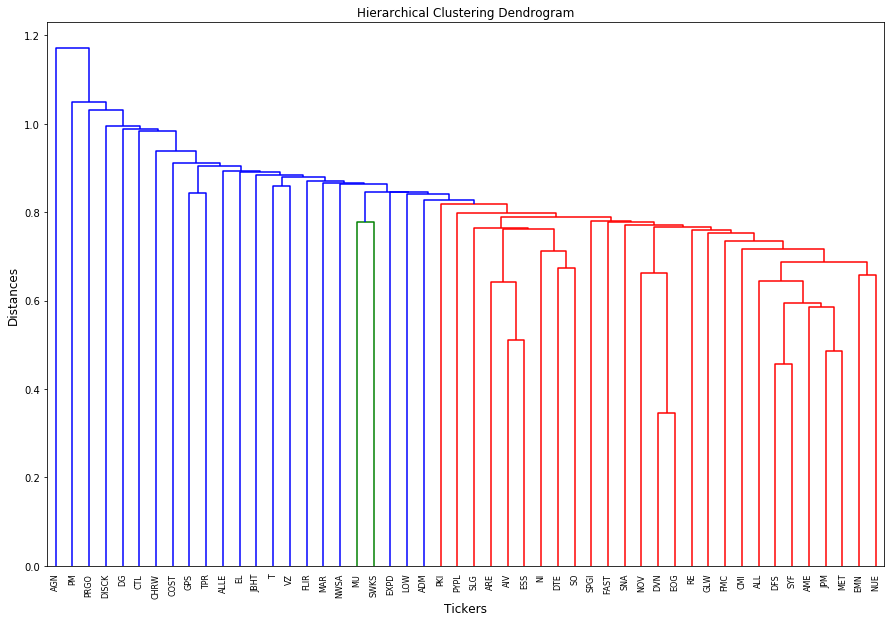

In [11]:
hc_single = linkage(squareform(distance_matrix), method="single")
ddata = dendrogram(hc_single, labels=distance_matrix.index)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=12)
plt.show()

As you can see, distances of sub-clusters are mostly concentrated, we can expect that it is not easy to get beautiful and nice clustering image. You can check details of the dendrogram below dataframe.

In [12]:
pd.DataFrame(hc_single, columns=['cluster_id_1', 'cluster_id_2', 'distance', 'number of members'],
             index=[ "cluster_{}".format(i+1) for i in range(hc_single.shape[0])]
            )

,cluster_id_1,cluster_id_2,distance,number of members
cluster_1,15.0,18.0,0.346869,2.0
cluster_2,11.0,46.0,0.457362,2.0
cluster_3,27.0,30.0,0.486907,2.0
cluster_4,2.0,19.0,0.509748,2.0
cluster_5,5.0,52.0,0.586114,3.0
cluster_6,51.0,54.0,0.593741,5.0
cluster_7,6.0,53.0,0.642848,3.0
cluster_8,3.0,55.0,0.644946,6.0
cluster_9,17.0,34.0,0.658835,2.0
cluster_10,33.0,50.0,0.662294,3.0


### Building MST based on distance matrix

In [13]:
pairs =list(itertools.combinations(tickers, 2)) 
edges = []
for a, b in pairs:
    edges.append((distance_matrix.loc[a,b], a, b))

In [14]:
edges.sort()

In [15]:
mst = MinimumSpanningTree(tickers, edges)
tree = mst.build()

The building of tree is completed


In [16]:
tree

[(0.3468686073752864, 'DVN', 'EOG'),
 (0.4573617879068249, 'DFS', 'SYF'),
 (0.4869069570100967, 'JPM', 'MET'),
 (0.5097476163635705, 'AIV', 'ESS'),
 (0.5861135491821754, 'AME', 'MET'),
 (0.5937408992884916, 'JPM', 'SYF'),
 (0.6428480632209306, 'AIV', 'ARE'),
 (0.6449455731797635, 'ALL', 'MET'),
 (0.6588354056569681, 'EMN', 'NUE'),
 (0.66229440749994, 'DVN', 'NOV'),
 (0.6730573788474928, 'DTE', 'SO'),
 (0.6868064062912486, 'MET', 'NUE'),
 (0.7125160525850077, 'DTE', 'NI'),
 (0.7160762289880247, 'CMI', 'EMN'),
 (0.735299999435005, 'FMC', 'MET'),
 (0.7525698155383791, 'CMI', 'GLW'),
 (0.7586727902020749, 'ALL', 'RE'),
 (0.7623992982242409, 'DTE', 'ESS'),
 (0.7639082518686938, 'ARE', 'SLG'),
 (0.7669288291240538, 'DVN', 'JPM'),
 (0.7706966382766683, 'CMI', 'SNA'),
 (0.7771742479352638, 'MU', 'SWKS'),
 (0.7782604114412082, 'FAST', 'NUE'),
 (0.7808004959763378, 'ALL', 'SPGI'),
 (0.7892516522896491, 'ALL', 'DTE'),
 (0.7973884443760831, 'PYPL', 'SPGI'),
 (0.8179272681821159, 'GLW', 'PKI'),
 (0

### MST colored by clustering

Let's graph our MST tree and color it by cluster that we just got from hierarchical clustering. As we expect, we can confirm clustering results are not great through tree graph.

In [17]:
NUM_CLUSTER = 11 # the number of sectors
cluster_info = cut_tree(hc_single, NUM_CLUSTER)
cluster_info = cluster_info.reshape(-1)

In [18]:
G = build_graph(tickers, tree)

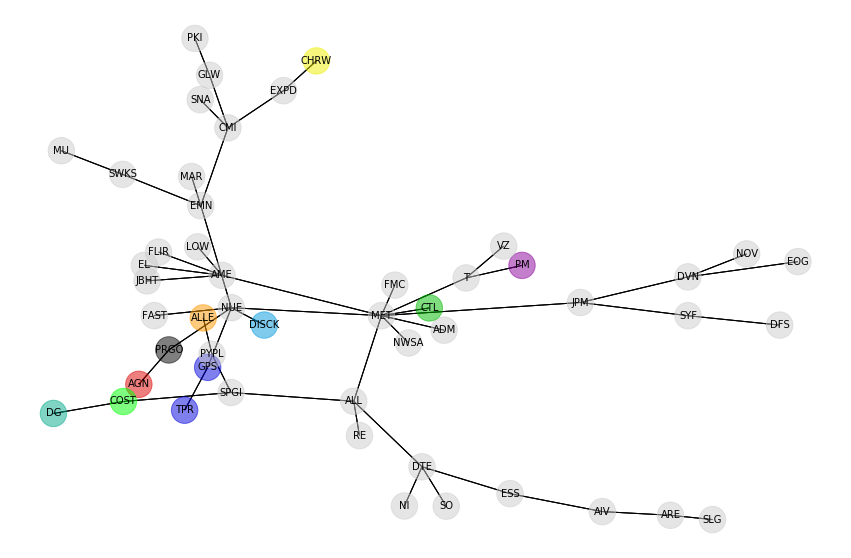

In [19]:
cmap = plt.cm.get_cmap('nipy_spectral_r', NUM_CLUSTER)
draw_graph(G, cluster_info, cmap, label=False)

### MST colored by sector

what if we draw sample graph with different color based on sector?

In [20]:
sector_map

{'ARE': 'Real Estate',
 'ALLE': 'Industrials',
 'AGN': 'Health Care',
 'ALL': 'Financials',
 'AME': 'Industrials',
 'AIV': 'Real Estate',
 'ADM': 'Consumer Staples',
 'T': 'Telecommunication Services',
 'CHRW': 'Industrials',
 'CTL': 'Telecommunication Services',
 'GLW': 'Information Technology',
 'COST': 'Consumer Staples',
 'CMI': 'Industrials',
 'DVN': 'Energy',
 'DFS': 'Financials',
 'DISCK': 'Consumer Discretionary',
 'DG': 'Consumer Discretionary',
 'DTE': 'Utilities',
 'EMN': 'Materials',
 'EOG': 'Energy',
 'ESS': 'Real Estate',
 'EL': 'Consumer Staples',
 'RE': 'Financials',
 'EXPD': 'Industrials',
 'FAST': 'Industrials',
 'FLIR': 'Information Technology',
 'FMC': 'Materials',
 'GPS': 'Consumer Discretionary',
 'JBHT': 'Industrials',
 'JPM': 'Financials',
 'LOW': 'Consumer Discretionary',
 'MAR': 'Consumer Discretionary',
 'MET': 'Financials',
 'MU': 'Information Technology',
 'NOV': 'Energy',
 'NWSA': 'Consumer Discretionary',
 'NI': 'Utilities',
 'NUE': 'Materials',
 'PYPL': 

In [21]:
sector_index

{'Real Estate': 0,
 'Financials': 1,
 'Information Technology': 2,
 'Utilities': 3,
 'Health Care': 4,
 'Industrials': 5,
 'Energy': 6,
 'Telecommunication Services': 7,
 'Consumer Staples': 8,
 'Consumer Discretionary': 9,
 'Materials': 10}

In [22]:
sector_info = []

for ticker in tickers:
    sector = sector_map[ticker]
    sector_num = sector_index[sector]
    sector_info.append(sector_num)

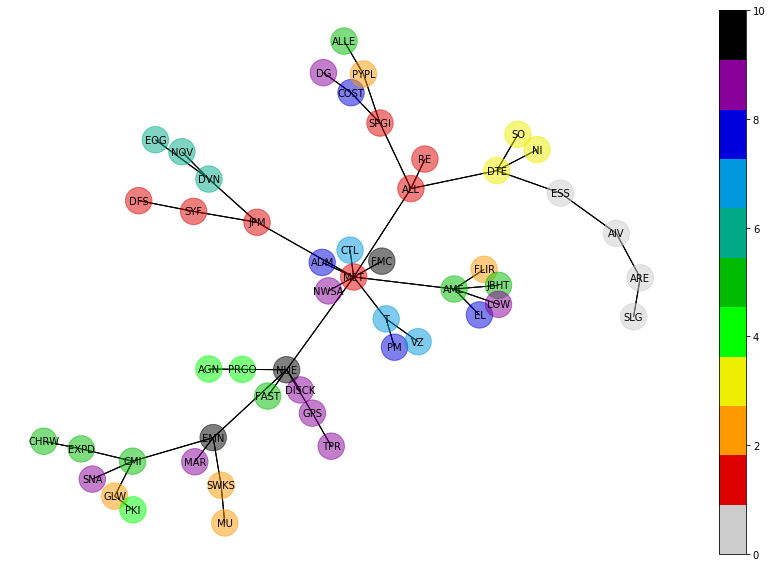

Label:0: Real Estate: ARE, AIV, ESS, SLG
Label:1: Financials: ALL, DFS, RE, JPM, MET, SPGI, SYF
Label:2: Information Technology: GLW, FLIR, MU, PYPL, SWKS
Label:3: Utilities: DTE, NI, SO
Label:4: Health Care: AGN, PKI, PRGO
Label:5: Industrials: ALLE, AME, CHRW, CMI, EXPD, FAST, JBHT
Label:6: Energy: DVN, EOG, NOV
Label:7: Telecommunication Services: T, CTL, VZ
Label:8: Consumer Staples: ADM, COST, EL, PM
Label:9: Consumer Discretionary: DISCK, DG, GPS, LOW, MAR, NWSA, SNA, TPR
Label:10: Materials: EMN, FMC, NUE


In [23]:
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=NUM_CLUSTER-1))
plt.colorbar(sm)
draw_graph(G, sector_info, cmap, label=False)

for sector_name, index in sector_index.items():
    print(f"Label:{index}: {sector_name}: {', '.join(ticker_info_df[ticker_info_df['Sector']==sector_name]['Symbol'])}")

- Our tree graph are good enough to show the assumption that the movements of stocks in the same sector would be similar.

# Use case of MST

we can use structure of MTS to de-noise distance matrix. 

We can filter $D$ by replacing $d_{i,j}$ to $d^{<}_{i, j} = max_{k}${$d_{ik}, d_{kj}$}

 $d^{<}_{i, j}$ is maximum distance among single steps in a path from $i$ to $j$ in a MST

In [24]:
def get_distance_in_mst(mst, stock_a, stock_b):
    """
    Return distance of path from stock_a to stock_b in a MST
    """
    _, distance = mst.find_path(stock_a, stock_b)
    return distance

def get_filtered_distance_in_mst(mst, stock_a, stock_b):
    """
    Return maximum distance among single steps in a path from stock_a to stock_b in a MST
    
    ex:
        >>>> get_distance_in_mts(mst, 'ADM', 'AGN')
        >>>> 1.170524
    """
    
    if stock_a == stock_b:
        return 0
    else:
        path, _ = mst.find_path(stock_a, stock_b)
        return max([get_distance_in_mst(mst, i, j) for i, j in zip(path, path[1:])])

In [25]:
filtered_ds_matrix = distance_matrix.copy(deep=True)

In [26]:
# update distance
num_changed = 0
diff_store = []
for stock_a, stock_b in itertools.combinations(distance_matrix.index, 2):
    original_distance = distance_matrix.loc[stock_a, stock_b]
    new_distance = get_filtered_distance_in_mst(mst, stock_a, stock_b)
    if original_distance != new_distance:
        num_changed +=1
        filtered_ds_matrix.loc[stock_a, stock_b] = new_distance
        print(f"Distance of pair: [{stock_a}, {stock_b}] is changed {original_distance:.4f} -> {new_distance:.4f}")
        diff = original_distance - new_distance
        diff_store.append((diff, stock_a, stock_b))

Distance of pair: [ADM, AGN] is changed 1.2579 -> 1.1705
Distance of pair: [ADM, AIV] is changed 1.0906 -> 0.8280
Distance of pair: [ADM, ALL] is changed 0.8811 -> 0.8280
Distance of pair: [ADM, ALLE] is changed 1.0657 -> 0.8921
Distance of pair: [ADM, AME] is changed 0.8740 -> 0.8280
Distance of pair: [ADM, ARE] is changed 1.0728 -> 0.8280
Distance of pair: [ADM, CHRW] is changed 1.1723 -> 0.9390
Distance of pair: [ADM, CMI] is changed 0.9173 -> 0.8280
Distance of pair: [ADM, COST] is changed 1.0709 -> 0.9113
Distance of pair: [ADM, CTL] is changed 1.0851 -> 0.9828
Distance of pair: [ADM, DFS] is changed 0.9190 -> 0.8280
Distance of pair: [ADM, DG] is changed 1.2100 -> 0.9886
Distance of pair: [ADM, DISCK] is changed 1.0530 -> 0.9937
Distance of pair: [ADM, DTE] is changed 1.0199 -> 0.8280
Distance of pair: [ADM, DVN] is changed 0.9558 -> 0.8280
Distance of pair: [ADM, EL] is changed 1.0875 -> 0.8903
Distance of pair: [ADM, EMN] is changed 0.8790 -> 0.8280
Distance of pair: [ADM, EOG]

Distance of pair: [ALLE, ESS] is changed 1.0964 -> 0.8921
Distance of pair: [ALLE, EXPD] is changed 1.0684 -> 0.8921
Distance of pair: [ALLE, FAST] is changed 1.0074 -> 0.8921
Distance of pair: [ALLE, FLIR] is changed 0.9954 -> 0.8921
Distance of pair: [ALLE, FMC] is changed 0.9830 -> 0.8921
Distance of pair: [ALLE, GLW] is changed 1.0306 -> 0.8921
Distance of pair: [ALLE, GPS] is changed 1.1542 -> 0.9041
Distance of pair: [ALLE, JBHT] is changed 1.0999 -> 0.8921
Distance of pair: [ALLE, JPM] is changed 0.9201 -> 0.8921
Distance of pair: [ALLE, LOW] is changed 1.0563 -> 0.8921
Distance of pair: [ALLE, MAR] is changed 1.0527 -> 0.8921
Distance of pair: [ALLE, MET] is changed 0.9510 -> 0.8921
Distance of pair: [ALLE, MU] is changed 1.0899 -> 0.8921
Distance of pair: [ALLE, NI] is changed 1.1342 -> 0.8921
Distance of pair: [ALLE, NOV] is changed 1.1490 -> 0.8921
Distance of pair: [ALLE, NUE] is changed 0.9861 -> 0.8921
Distance of pair: [ALLE, NWSA] is changed 1.0940 -> 0.8921
Distance of

Distance of pair: [DISCK, MAR] is changed 1.0149 -> 0.9937
Distance of pair: [DISCK, MET] is changed 1.0064 -> 0.9937
Distance of pair: [DISCK, MU] is changed 1.1536 -> 0.9937
Distance of pair: [DISCK, NI] is changed 1.3303 -> 0.9937
Distance of pair: [DISCK, NOV] is changed 1.1337 -> 0.9937
Distance of pair: [DISCK, NWSA] is changed 1.0326 -> 0.9937
Distance of pair: [DISCK, PKI] is changed 1.0940 -> 0.9937
Distance of pair: [DISCK, PM] is changed 1.2730 -> 1.0487
Distance of pair: [DISCK, PRGO] is changed 1.1847 -> 1.0298
Distance of pair: [DISCK, PYPL] is changed 1.1817 -> 0.9937
Distance of pair: [DISCK, RE] is changed 1.2329 -> 0.9937
Distance of pair: [DISCK, SLG] is changed 1.1608 -> 0.9937
Distance of pair: [DISCK, SNA] is changed 1.0747 -> 0.9937
Distance of pair: [DISCK, SO] is changed 1.3846 -> 0.9937
Distance of pair: [DISCK, SPGI] is changed 1.1494 -> 0.9937
Distance of pair: [DISCK, SWKS] is changed 1.0692 -> 0.9937
Distance of pair: [DISCK, SYF] is changed 1.0910 -> 0.99

we can see the distaces are chainging

In [27]:
total_pair = len(list(itertools.combinations(distance_matrix.index, 2)))
print(f"total {num_changed*100/total_pair:2.2f}% distances are changed")

total 96.00% distances are changed


Also, we can check that upper triangular part of matrix is changed below

In [28]:
filtered_ds_matrix.head()

,ADM,AGN,AIV,ALL,ALLE,AME,ARE,CHRW,CMI,COST,...,RE,SLG,SNA,SO,SPGI,SWKS,SYF,T,TPR,VZ
ADM,0.000000,1.170525,0.827996,0.827996,0.892054,0.827996,0.827996,0.939029,0.827996,0.911257,...,0.827996,0.827996,0.827996,0.827996,0.827996,0.845789,0.827996,0.880133,0.904135,0.880133
AGN,1.257855,0.000000,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,...,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525,1.170525
AIV,1.090633,1.312443,0.000000,0.789252,0.892054,0.789252,0.642848,0.939029,0.789252,0.911257,...,0.789252,0.763908,0.789252,0.762399,0.789252,0.845789,0.789252,0.880133,0.904135,0.880133
ALL,0.881133,1.256959,0.940749,0.000000,0.892054,0.644946,0.789252,0.939029,0.716076,0.911257,...,0.758673,0.789252,0.770697,0.789252,0.780800,0.845789,0.644946,0.880133,0.904135,0.880133
ALLE,1.065659,1.248871,1.051387,0.968112,0.000000,0.892054,0.892054,0.939029,0.892054,0.911257,...,0.892054,0.892054,0.892054,0.892054,0.892054,0.892054,0.892054,0.892054,0.904135,0.892054


# Clustering based on filtered distance

### Is there any change in dendrograms due to the filtering?

It's hard to find to difference of hierarchical clustering  with 'single' method from new distances. So, I chosse 'complete' method to show the effect of de-noise tric. because our de-noise trick basically changes rather long distance to existing short distance that already we know.

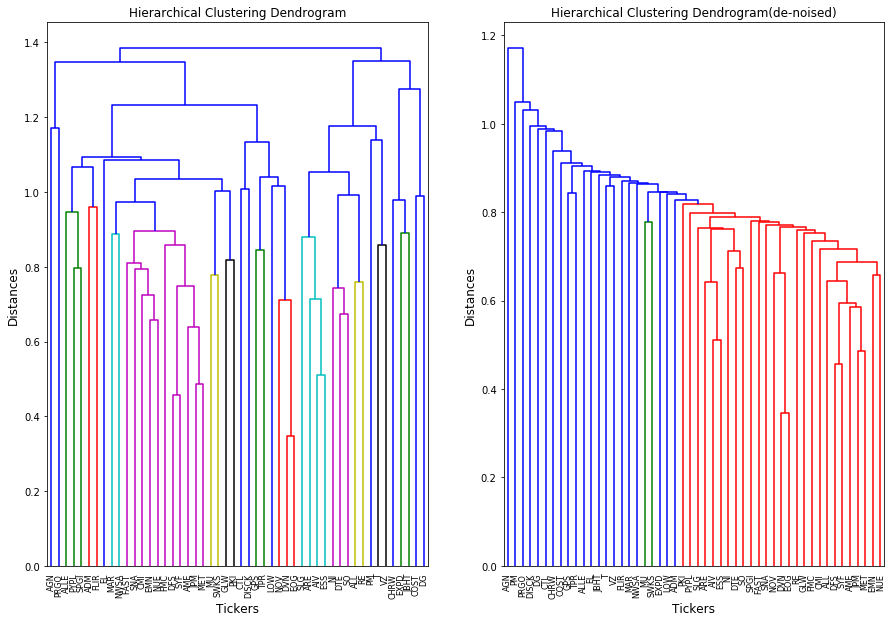

In [29]:
plt.subplot(121)
hc_complete = linkage(squareform(distance_matrix), method="complete")
ddata = dendrogram(hc_complete, labels=distance_matrix.index)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=12)

plt.subplot(122)
new_hc_complete = linkage(get_condensed_distance_matrix(filtered_ds_matrix.to_numpy()), method="complete")
ddata = dendrogram(new_hc_complete, labels=filtered_ds_matrix.index)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram(de-noised)', fontsize=12)
plt.show()

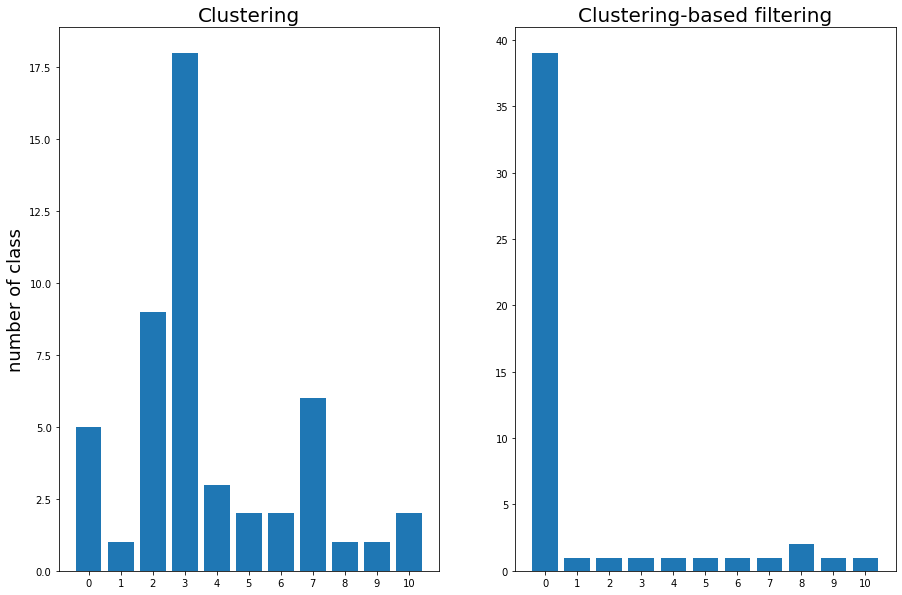

In [30]:
plt.subplot(121)
plt.title('Clustering', fontsize=20)
info = cut_tree(hc_complete, NUM_CLUSTER).reshape(-1)
ni = Counter(info)
nh = list(ni.values())
xpos = np.arange(NUM_CLUSTER)
rects = plt.bar(xpos, nh, align='center')
plt.xticks(xpos)
plt.ylabel('number of class', fontsize=18)

plt.subplot(122)
plt.title('Clustering-based filtering', fontsize=20)
info = cut_tree(new_hc_complete, NUM_CLUSTER).reshape(-1)
ni = Counter(info)
nh = list(ni.values())
xpos = np.arange(NUM_CLUSTER)
rects = plt.bar(xpos, nh, align='center')
plt.xticks(xpos)
plt.show()

As you can see, the variance of distance between clusters are decreased and many stocks have turned to one cluster(0). 

### Where can we apply this?

As below, many pairs of distance decreased considerably and variance of distances decreased. So, we can use this in terms of correlation change. I believe this method might be a helpful to porfolio optimization because stock data are generally known to have a low signal to noise ratio.

#### ex)

In [31]:
# The biggest chagne in pairs.
diff_store.sort()
diff_store[-5:]

[(0.4805914835281173, 'SNA', 'SO'),
 (0.48199496868945446, 'NOV', 'SO'),
 (0.4823168478523626, 'MAR', 'SO'),
 (0.48357925705486515, 'MU', 'SO'),
 (0.48372006069471096, 'CMI', 'SO')]

Thanks for reading!